# Introduction

In this notebook, I am going to build a recommendation system using deep learning trained on dataset of the famous Netflix Challenge competition.

The Netflix Challenge was an open competition to find the best collaborative filtering algorithm to predict user ratings for movies.
This challenge would be very useful for any practical application of predicting user's future rating and product's recommendation.

The dataset consists of ratings for 17,770 movies by 2,649,430 users. The challenge's goal is to develop a system that could beat the RMSE accuracy of 0.9514 from their in-house developed recommendation system (the Cinematch) by 10%. In 2009, the prize was awarded to team ”BellKor’s Pragmatic Chaos” with RMSE of 0.8567 or 10.06% improvement. However, most of winning solutions at that time was (too) complex and hard to be put into production.

Moreover, to process this whole massive and sparse matrix dataset (only around 1 % of the entries are non-zero/rated), it would take days to complete the whole training. Therefore for the sake of showing a new solution of deep learning, I would only process a smaller dataset of 2000 top rated movies and 10,000 top users (who gave the most rates). By focusing on this top 11% movies and 0.4% users, I still can retain 10% of the ratings from the whole data.

In this notebook, I am showing a recommendation system with Keras deep learning, which is quite simple but still can achieve decent accuracy. 



Setup:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.layers import Concatenate, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

/kaggle/input/netflix-prize-data/combined_data_3.txt
/kaggle/input/netflix-prize-data/movie_titles.csv
/kaggle/input/netflix-prize-data/combined_data_4.txt
/kaggle/input/netflix-prize-data/combined_data_1.txt
/kaggle/input/netflix-prize-data/README
/kaggle/input/netflix-prize-data/probe.txt
/kaggle/input/netflix-prize-data/combined_data_2.txt
/kaggle/input/netflix-prize-data/qualifying.txt


# Importing Data 

As the raw data format is not readable as csv file, we need some pre-process steps to convert it into csv format and then import to pandas dataframe later


In [2]:
%%time
## coiuld replace with pd.read_csv and dropping NaNs/ : cols ? 

# DataFrame to store all imported data
if not os.path.isfile('data.csv'):
    data = open('data.csv', mode='w')

files = ['../input/netflix-prize-data/combined_data_1.txt',
         '../input/netflix-prize-data/combined_data_2.txt',
#          '../input/netflix-prize-data/combined_data_3.txt',  # read in half of data only for speedup
#          '../input/netflix-prize-data/combined_data_4.txt'
        ]

# Remove the line with movie_id: and add a new column of movie_id
# Combine all data files into a csv file
for file in files:
  print("Opening file: {}".format(file))
  with open(file) as f:
    for line in f:
        line = line.strip()
        if line.endswith(':'):
            movie_id = line.replace(':', '')
        else:
            data.write(movie_id + ',' + line)
            data.write('\n')
data.close()

# Read all data into a pd dataframe
df = pd.read_csv('data.csv', names=['movie_id', 'user_id','rating','date'])
print(df.nunique())
df

Opening file: ../input/netflix-prize-data/combined_data_1.txt
Opening file: ../input/netflix-prize-data/combined_data_2.txt
movie_id      9210
user_id     478018
rating           5
date          2182
dtype: int64
CPU times: user 1min 48s, sys: 10.6 s, total: 1min 58s
Wall time: 1min 58s


,movie_id,user_id,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03
...,...,...,...,...
51031350,9210,2420260,1,2003-12-01
51031351,9210,761176,3,2004-06-06
51031352,9210,459277,3,2005-02-25
51031353,9210,2407365,4,2005-04-29


# Pre-process data

From dataframe df, let's take only a smaller dataset of 2,000 top rated movies and 10,000 top users (who gave the most rates) and save into new df: lite_rating_df

In [3]:
lite_rating_df = pd.DataFrame()

group = df.groupby('user_id')['rating'].count()
top_users = group.sort_values(ascending=False)[:10000]

group = df.groupby('movie_id')['rating'].count()
top_movies = group.sort_values(ascending=False)[:2000]

lite_rating_df = df.join(top_users, rsuffix='_r', how='inner', on='user_id')
lite_rating_df = lite_rating_df.join(top_movies, rsuffix='_r', how='inner', on='movie_id')

# Re-name the users and movies for uniform name from 0..2000 and 10000
user_enc = LabelEncoder()
lite_rating_df['user'] = user_enc.fit_transform(lite_rating_df['user_id'].values)
movie_enc = LabelEncoder()
lite_rating_df['movie'] = movie_enc.fit_transform(lite_rating_df['movie_id'].values)

n_movies = lite_rating_df['movie'].nunique()
n_users = lite_rating_df['user'].nunique()

# print(n_movies, n_users)
lite_rating_df

,movie_id,user_id,rating,date,rating_r,rating_r,user,movie
5149,8,1488844,4,2005-05-12,1127,14910,5609,0
5883,8,1227322,5,2005-05-31,2467,14910,4610,0
6183,8,525356,4,2005-08-26,2555,14910,1942,0
6310,8,401047,2,2005-06-15,1087,14910,1464,0
7140,8,883478,5,2005-10-10,1642,14910,3264,0
...,...,...,...,...,...,...,...,...
43558457,7673,733887,2,2002-06-19,908,4204,2697,1657
43558566,7673,2352586,3,2002-06-27,601,4204,8841,1657
43557096,7673,2311863,3,2004-06-23,799,4204,8692,1657
43558277,7673,385136,2,2005-03-11,628,4204,1393,1657


Prepare data for training

In [4]:
X = lite_rating_df[['user', 'movie']].values
y = lite_rating_df['rating'].values

# Split train and test data (for test model performance at last)
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.1)

# Split train and validation data (to monitor model performance in training)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.1)

# Set the embedding dimension d of Matrix factorization
e_dimension = 200 # was 50

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_val_array = [X_val[:, 0], X_val[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]


# Build and train deep learning model

The embeddings is used to represent each user and each movie in the data. 
The dot product of user embedding matrix (size: n_users x e_dimension) and movie embedding matrix (size: n_movies x e_dimension) is a good approximation of the rating from user for movie. The model's goal is to minimize the distqace between this dot product and the ratings (training target)


In [5]:
# Build user and movie embedding matrix
user = Input(shape=(1,))
u = Embedding(n_users, e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-7))(user) # embedding was 1e-6
u = Reshape((e_dimension,))(u)
movie = Input(shape=(1,))
m = Embedding(n_movies, e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-7))(movie)  # embedding was 1e-6
m = Reshape((e_dimension,))(m)

x = Dot(axes=1)([u, m])
## new : concat user, id along with dot
x = Concatenate()([u, m,x])
x = Dropout(0.2)(x)

# Build last deep learning layers 
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.2)(x)
x = Dense(1)(x)

model = Model(inputs=[user, movie], outputs=x)
model.compile(loss='mean_squared_error', 
              optimizer=Adam(lr=0.003),  ## 0.001
              metrics=[tf.keras.metrics.RootMeanSquaredError()]
              )

# Set up for early stop if the validation loss stop improving for more than 1 epoch
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=1,
                                                ),
                  # Saves the weights after every epoch
                  keras.callbacks.ModelCheckpoint(  
                      filepath='Model_1',
                      monitor='val_loss',
                      save_best_only=True,
                      )]

# Print model info summary
model.summary()  

history = model.fit(x=X_train_array, y=y_train, batch_size=64,
                    epochs=10, # 20
                    verbose=1, 
                    callbacks=callbacks_list,
                    validation_data=(X_val_array, y_val)
                    )

# Save the model (we should make a good habit of always saving our models after training)
model.save("Model_1")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 200)       2000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 200)       400000      input_2[0][0]                    
______________________________________________________________________________________________

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


82555/82555 [==============================] - 1131s 14ms/step - loss: 0.8613 - root_mean_squared_error: 0.9112 - val_loss: 0.8142 - val_root_mean_squared_error: 0.8761
Epoch 2/10
82555/82555 [==============================] - 1139s 14ms/step - loss: 0.8197 - root_mean_squared_error: 0.8744 - val_loss: 0.7641 - val_root_mean_squared_error: 0.8388
Epoch 3/10
82555/82555 [==============================] - 1202s 15ms/step - loss: 0.7987 - root_mean_squared_error: 0.8552 - val_loss: 0.7606 - val_root_mean_squared_error: 0.8309
Epoch 4/10
82555/82555 [==============================] - 1121s 14ms/step - loss: 0.7871 - root_mean_squared_error: 0.8430 - val_loss: 0.7575 - val_root_mean_squared_error: 0.8240
Epoch 5/10
82555/82555 [==============================] - 1115s 14ms/step - loss: 0.7753 - root_mean_squared_error: 0.8315 - val_loss: 0.7681 - val_root_mean_squared_error: 0.8265


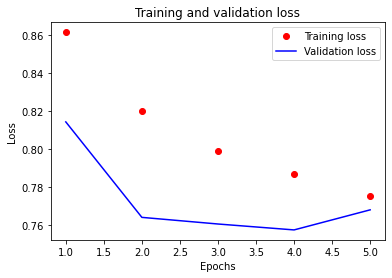

In [6]:
# Visualize the training and validation loss

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Test final model in the test data:

In [7]:
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(model.predict(X_test_array), y_test)
m.result().numpy()


0.82477474

# Conclusion

In the test result, we can see that our model's RMSE is 0.7731, which is quite good and seemingly so much improved from the Cinematch's performance (0.9514) or the prize winner team ”BellKor’s Pragmatic Chaos” (0.8567) but that is not really true. As our model have not trained in the original massive dataset with more sparse matrix and testing in the qualifying dataset (Netflix's test data) is not possible since the competition closed, any comparation would hardly be correct.

Therefore, in this notebook, my main purpose is to show a deep learning approach to the challenge which is simple and effective to apply with a decent accuracy. 
Any comment about further improvement or correction would be very welcome.


References:

[1] https://developers.google.com/machine-learning/recommendation/collaborative/matrix

[2] https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/

[3] Nicholas Ampazis. Large Scale Problem Solving with Neural Networks: The Netflix Prize Case, 2010

[4] Cyril GarciaJ, et al. The Netflix Challenge, 2018

[5] François Chollet, Deep Learning with Python, 2018
